# Introduction

1. **Translation Model**:
In this homework assignment, the initial focus is on implementing a Translation Model. This component aims to facilitate language translation, using the Seamless model.

2. **ClipCap Model**:
The second major section involves the creation of a Captioner model utilizing CLIP. This model is designed to generate captions, in response to visual input.

3. **ClipCap + Translation**:
The final part of the notebook combines the capabilities of the ClipCap model with the Translation Model. This integration suggests a comprehensive solution where CLIP-generated captions are subsequently translated into Farsi using the Seamless model.

# Imports

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install open-flamingo
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 kB 886.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import clip
import torch
import PIL.Image
import numpy as np
from torch import nn
from enum import Enum
import skimage.io as io
import torch.nn.functional as nnf
from typing import Tuple, List, Union, Optional
from transformers import AutoProcessor, SeamlessM4TModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


# Drive Downloader

Don't touch this part !!

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive

        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_dst):
        if self.use_pydrive:
            downloaded = self.drive.CreateFile({'id':file_id})
            downloaded.FetchMetadata(fetch_all=True)
            downloaded.GetContentFile(file_dst)
        else:
            !gdown --id $file_id -O $file_dst

downloader = Downloader(download_with_pydrive)

# Translation

In this segment, our objective is to employ a pre-existing translation model for converting text between English and Farsi. Your task is to finalize the provided functions and test them on the provided texts.

In [4]:
processor = AutoProcessor.from_pretrained("facebook/hf-seamless-m4t-medium")
model_seamless = SeamlessM4TModel.from_pretrained("facebook/hf-seamless-m4t-medium")

preprocessor_config.json:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/4.33k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/2.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/5.35k [00:00<?, ?B/s]

In [5]:
def translate_english_to_persian(text):

    # ======================================= Code =======================================
    inputs = processor(text, src_lang = "eng", return_tensors="pt", padding=True, truncation=True)
    output_tokens = model_seamless.generate(**inputs , tgt_lang = "pes", generate_speech=False)
    translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
    # ======================================= Code =======================================

    return translated_text_from_text

In [6]:
translate_english_to_persian('Levi is the best anime character ever!')

'لوي بهترين کاراکتر انيمي تا حالا است!'

In [7]:
def translate_persian_to_english(text):

    # ======================================= Code =======================================
    inputs = processor(text, src_lang = "pes", return_tensors="pt", padding=True, truncation=True)
    output_tokens = model_seamless.generate(**inputs , tgt_lang = "eng", generate_speech=False)
    translated_text_from_text = processor.decode(output_tokens[0].tolist()[0], skip_special_tokens=True)
    # ======================================= Code =======================================

    return translated_text_from_text

In [8]:
translate_persian_to_english('انسان به منافع هیچ موجودی جز خود نمی‌اندیشد')

'Man has no interest in anything but himself.'

# ClipCap


In this part, our goal is to complete the implementation of the ClipCap model. To achieve this, it's crucial to thoroughly review the associated paper to understant the model's functioning. Please ensure that modifications are solely made within the specified section, avoiding alterations elsewhere in the model to prevent potential issues when loading weights.

## Base Modules

Don't touch this either :)

In [9]:
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'


class MlpTransformer(nn.Module):
     def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
         super().__init__()
         out_d = out_d if out_d is not None else in_dim
         self.fc1 = nn.Linear(in_dim, h_dim)
         self.act = act
         self.fc2 = nn.Linear(h_dim, out_d)
         self.dropout = nn.Dropout(dropout)

     def forward(self, x):
         x = self.fc1(x)
         x = self.act(x)
         x = self.dropout(x)
         x = self.fc2(x)
         x = self.dropout(x)
         return x

class MLP(nn.Module):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention


class TransformerLayer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)


class Transformer(nn.Module):

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec: # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)


class TransformerMapper(nn.Module):

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)

## Main Modules

In [10]:
class ClipCaptionModel(nn.Module):

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                                     clip_length, num_layers)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):

        # ==================================== Code ====================================
        embedding_text = self.gpt.transformer.wte(tokens)

        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)

        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = torch.zeros(tokens.shape[0], self.prefix_length, dtype=torch.int64, device=device)
            #dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out
        # ==================================== Code (End) ====================================
class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

## Caption Generation Functions


In this section, you are to implement two decoding strategies, specifically, both greedy and beam search. Your task involves completing the provided functions dedicated to these strategies.

In [32]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate_simple(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / temperature
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

## Generate

In [12]:
pretrained_model = 'COCO'
model_path = './model_wieghts.pt'
current_directory = os.getcwd()

downloader.download_file("1GYPToCqFREwi285wPLhuVExlz7DDUDfJ", model_path)
is_gpu = False
device = 'cuda:0' if is_gpu else "cpu"
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

100%|███████████████████████████████████████| 402M/402M [00:05<00:00, 82.2MiB/s]


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [13]:
prefix_length = 40
model = ClipCaptionPrefix(prefix_length, clip_length=40, prefix_size=640, num_layers=8, mapping_type='transformer')
model.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)
model = model.eval()
model = model.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [14]:
# ['562207', '579664', '060623', '165547', '334321', '483108', '386164', '354533']
IMAGE_NAME = '334321'

name_ = "COCO_val2014_000000" + IMAGE_NAME + ".jpg"
images_path = os.path.join(os.path.dirname(current_directory), "images")
os.makedirs(images_path, exist_ok=True)
UPLOADED_FILE = os.path.join(images_path, name_)

if not os.path.isfile(UPLOADED_FILE):
  download_path = os.path.join(images_path, "images.zip")
  downloader.download_file("1l6J9WFYxpF-1HFr3A5Oq1eoObTxzbPgs", download_path)
  !unzip {download_path} -d {images_path}

Archive:  /images/images.zip
  inflating: /images/COCO_val2014_000000060623.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000060623.jpg  
  inflating: /images/COCO_val2014_000000165547.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000165547.jpg  
  inflating: /images/COCO_val2014_000000334321.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000334321.jpg  
  inflating: /images/COCO_val2014_000000354533.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000354533.jpg  
  inflating: /images/COCO_val2014_000000386164.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000386164.jpg  
  inflating: /images/COCO_val2014_000000483108.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000483108.jpg  
  inflating: /images/COCO_val2014_000000562207.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000562207.jpg  
  inflating: /images/COCO_val2014_000000579664.jpg  
  inflating: /images/__MACOSX/._COCO_val2014_000000579664.jpg  


In the next cell use the ClipCap model to generate captions for the image.

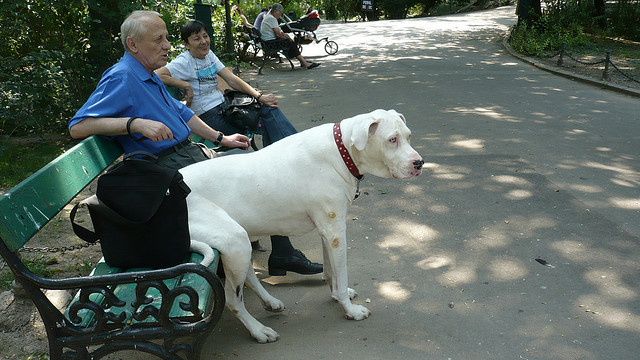

Generated Captions:
1. A couple of people sitting on a bench next to a white horse.
2. A couple of people sitting on a bench next to a white dog.
3. Two people sitting on a bench next to a white horse.
4. A couple of people sitting on a bench with a white dog.
5. Two people sitting on a bench next to a white dog.


In [15]:
use_beam_search = True
image = io.imread(UPLOADED_FILE)
pil_image = PIL.Image.fromarray(image)
display(pil_image)

# ==================================== Code (Begin) ====================================
model.eval()

image = preprocess(pil_image).unsqueeze(0).to(device)

prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

with torch.no_grad():
    if use_beam_search:
        captions = generate_beam(model, tokenizer, beam_size=5, embed=prefix_embed)
    else:
        captions = generate_simple(model, tokenizer, tokens=None, embed=prefix_embed, entry_count=1)

# Display the generated captions
print("Generated Captions:")
for i, caption in enumerate(captions):
    print(f"{i + 1}. {caption}")


# ==================================== Code (End) ====================================

# ClipCap + Seamless

Finally, your task is to employ the Seamless model to translate the generated captions into Farsi.

In [16]:
# ==================================== Code (Begin) ====================================
#processor = AutoProcessor.from_pretrained("facebook/hf-seamless-m4t-medium")
#model = SeamlessM4TModel.from_pretrained("facebook/hf-seamless-m4t-medium")

for i, caption in enumerate(captions):
    print(caption)
    translated_text = translate_english_to_persian(caption)
    print(translated_text)
    print()
# ==================================== Code (End) ====================================

A couple of people sitting on a bench next to a white horse.
چند نفر روی نیمکت کنار یک اسب سفید نشسته اند.

A couple of people sitting on a bench next to a white dog.
چند نفر روی نیمکت کنار یک سگ سفید نشسته اند.

Two people sitting on a bench next to a white horse.
دو نفر روی نیمکت کنار یک اسب سفید نشسته اند.

A couple of people sitting on a bench with a white dog.
چند نفر روی نیمکت با یک سگ سفید نشسته اند.

Two people sitting on a bench next to a white dog.
دو نفر روی نیمکت کنار یک سگ سفید نشسته اند.



# Evaluation

In order to evaluate your model, first you need to prepare a dataset with 100 pairs of image and Farsi captions. For this you can use the images and captions available in the COCO dataset (you need to translate the captions to Farsi). Then use your model to predict captions for the images and finally use common metrics such as BLEU to evaluate your model.

In [33]:
# ==================================== Code (Begin) ====================================
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

from zipfile import ZipFile, BadZipFile
import os

def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)

        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)

    except BadZipFile as e:
        print("Error:", e)


extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"

extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)
# ==================================== Code (End) ====================================

--2023-12-20 13:51:04--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.10.151, 52.216.92.195, 3.5.9.21, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.10.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘coco_train2017.zip’

coco_train2017.zip    1%[                    ] 194.35M  21.6MB/s    eta 11m 20s^C
--2023-12-20 13:51:12--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.20, 3.5.25.148, 52.217.136.177, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  10.8MB/s    in 37s     

2023-12-20 13:51:48 (21.1 MB/s) - ‘coco_val2017.zip’ saved 

In [34]:
import json
import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
train_captions = json.load(open("/content/coco_ann2017/annotations/captions_train2017.json"))
val_captions = json.load(open("/content/coco_ann2017/annotations/captions_val2017.json"))

In [48]:
#from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu

def create_image_caption_dataset(path , json_file):
    dataset = []

    model.eval()
    bleu_score_all = []
    for i , image_path in enumerate(tqdm(glob.iglob(path + "**/*.jpg"))):
        image = Image.open(image_path)
        image_name = image_path.split("/")[-1]
        image = preprocess(pil_image).unsqueeze(0).to(device)

        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

        predicted_caption = generate_simple(model, tokenizer, tokens=None, embed=prefix_embed, entry_count=1)

        predicted_caption_persian = translate_english_to_persian(predicted_caption)
        #print(predicted_caption_persian)
        all_ground_truth = []
        for element in json_file['images']:
            if element['file_name'] == image_name:
                this_image_id = element['id']
                for eleman in json_file['annotations']:
                    if eleman['image_id'] == this_image_id:
                        this_caption = eleman['caption']
                        ground_truth_caption_persian = translate_english_to_persian(this_caption)
                        all_ground_truth.append(ground_truth_caption_persian)

        max_bleu = 0
        all_b = []
        for ground_truth_cap in all_ground_truth:
                print(ground_truth_cap.split(), predicted_caption_persian.split())
                bleu_score = sentence_bleu(
                    ground_truth_cap.split(),
                    predicted_caption_persian.split(),
                    weights=(1,0,0,0))
                if bleu_score > max_bleu:
                    max_bleu = bleu_score
                    #all_b.append(max_bleu)
        bleu_score_all.append(max_bleu)
        print(max_bleu)
        if i == 10:
            break

    mean_bleu = sum(bleu_score_all)/len(bleu_score_all)


    return mean_bleu

In [49]:
mean_bleu = create_image_caption_dataset(path = "/content/coco_train2017/train2017" , json_file = train_captions)

1it [00:25, 25.44s/it]

['زنی', 'که', 'در', 'بیرون', 'یک', 'ساختمان', 'ایستاده', 'و', 'به', 'تلفن', 'همراهش', 'نگاه', 'می', 'کند'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'با', 'کت', 'زرد', 'در', 'حال', 'بررسی', 'تلفن', 'خود', 'در', 'حالی', 'که', 'در', 'یک', 'پلتفرم', 'مترو', 'ایستاده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'زن', 'وقتی', 'قطار', 'پشت', 'سرش', 'می', 'آید،', 'تلفن', 'همراه', 'خود', 'را', 'بررسی', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'که', 'در', 'حالی', 'که', 'از', 'یک', 'اتوبوس', 'زرد', 'عبور', 'می', 'کند،', 'روی', 'تلفن', 'همراه', 'تمرکز', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'که', 'با', 'یک', 'دوربین', 'راه', 'می', 'رود'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


2it [00:46, 22.78s/it]

['زنی', 'که', 'از', 'ظرف', 'هایی', 'با', 'غذا', 'می', 'خورد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'با', 'پیراهن', 'خاکستری', 'که', 'از', 'میز', 'غذا', 'می', 'خورد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'که', 'دونات،', 'کروسانت،', 'میوه', 'و', 'لیوان', 'شامپانزه', 'می', 'خورد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'که', 'در', 'یک', 'میز', 'گرد', 'کوچک', 'غذا', 'می', 'خورد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'زن', 'بلوند', 'با', 'دو', 'وعده', 'غذا', 'و', 'نوشیدنی.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


3it [01:09, 23.14s/it]

['دو', 'زراف', 'که', 'در', 'حال', 'ایستادن', 'در', 'فاصله', 'ای', 'آزاد', 'هستند،', 'یک', 'زراف', 'را', 'در', 'درختان', 'پنهان', 'می', 'کنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['دو', 'زرافه', 'در', 'چمن', 'نزدیک', 'درختان', 'ایستاده', 'اند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['چند', 'تا', 'زرافه', 'خيلي', 'قشنگ', 'در', 'يه', 'منطقه', 'جنگل', 'دار'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['سه', 'زراف', 'در', 'یک', 'باغ', 'درختان', 'کوچک', 'ایستاده', 'اند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['چند', 'تا', 'زراف', 'در', 'یک', 'زمین', 'ایستاده', 'اند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


4it [01:31, 22.43s/it]

['گروهی', 'از', 'جت', 'های', 'نیروی', 'هوایی', 'اطلاعات', 'پرواز', 'می', 'کنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'اسکادران', 'از', 'جت', 'های', 'جنگی', 'که', 'در', 'آسمان', 'آبی', 'در', 'شکل', 'گیری', 'پرواز', 'می', 'کنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['چهار', 'جت', 'هواپيما', 'با', 'دود', 'پرواز', 'ميکنن'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['چهار', 'هواپيما', 'در', 'آسمان', 'آبی', 'پرواز', 'ميکنن'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['جت', 'ها', 'در', 'حال', 'پرواز', 'در', 'شکل', 'در', 'آسمان', 'هستند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


5it [01:54, 22.67s/it]

['یک', 'کامیون', 'سفید', 'در', 'یک', 'گاراژ', 'پارک', 'شده', 'با', 'کامیون', 'دیگری', 'در', 'کنار', 'آن.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'کامیون', 'قدیمی', 'در', 'کنار', 'کامیون', 'های', 'دیگر', 'پارک', 'می', 'شود.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'کامیون', 'سفید', 'تجاری', 'که', 'در', 'یک', 'گاراژ', 'پارک', 'شده', 'است'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['کامیون', 'بزرگ', 'با', 'کامیون', 'های', 'دیگر', 'پارک', 'شده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'کامیون', 'کوچک', 'سفید', 'در', 'کنار', 'یک', 'کامیون', 'سبز', 'و', 'سفید', 'پارک', 'شده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


6it [02:17, 22.86s/it]

['گله', 'ای', 'از', 'فیل', 'ها', 'در', 'چمن', 'های', 'بلند', 'چمن', 'می', 'زنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['فیل', 'بزرگی', 'در', 'کنار', 'فیل', 'کوچک', 'در', 'یک', 'میدان', 'چمن', 'بلند', 'با', 'سایر', 'حیوانات', 'در', 'پشت', 'ایستاده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['بعضی', 'از', 'حیوانات', 'در', 'روز', 'آفتابی', 'در', 'چمن', 'های', 'بلند', 'قدم', 'می', 'زنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['مادر', 'فیل', 'با', 'بچه', 'اش', 'راه', 'می', 'رود.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['فیل', 'و', 'یک', 'فیل', 'کوچک', 'در', 'یک', 'زمین', 'با', 'چمن', 'بلند', 'هستند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


7it [02:37, 22.05s/it]

['گله', 'ای', 'از', 'فیل', 'ها', 'در', 'یک', 'میدان', 'چمن.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'گله', 'فیل', 'از', 'میان', 'چمن', 'های', 'بلند', 'قدم', 'می', 'زنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['گروهی', 'از', 'فیل', 'ها', 'با', 'یک', 'نوزاد', 'در', 'محیط', 'طبیعی.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['بعضی', 'از', 'فیل', 'ها', 'در', 'وسط', 'زمین', 'سفر', 'می', 'کنند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['گله', 'ای', 'از', 'فیل', 'ها', 'از', 'میان', 'چمن', 'های', 'بلند', 'می', 'روند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


8it [03:02, 22.83s/it]

['مردی', 'با', 'یک', 'بادبادک', 'سبز', 'که', 'به', 'آسمان', 'نگاه', 'می', 'کند', 'و', 'روی', 'یک', 'ساختمان', 'تاریخی', 'سنگی', 'ایستاده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['مردی', 'که', 'روی', 'دیوار', 'زیر', 'آسمان', 'آبی', 'ایستاده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['مردی', 'روی', 'بالای', 'یک', 'ساختمان', 'که', 'در', 'حالی', 'که', 'به', 'بالا', 'نگاه', 'می', 'کند،', 'یک', 'بادبادک', 'را', 'در', 'دست', 'دارد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['پسر', 'روی', 'بالای', 'یک', 'ساختمان', 'بلند', 'ایستاده', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['مردی', 'که', 'یک', 'بادبادک', 'را', 'روی', 'یک', 'ساختمان', 'نگه', 'دارد.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


9it [03:26, 23.29s/it]

['زنی', 'که', 'با', 'یک', 'وسیله', 'نقلیه', 'سیاه', 'در', 'کنار', 'خیابان', 'در', 'پیاده', 'رو', 'قدم', 'می', 'زند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['مردم', 'در', 'پیاده', 'رو', 'قدم', 'می', 'زنند', 'در', 'حالی', 'که', 'یک', 'کامیون', 'در', 'خیابان', 'عبور', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'خیابان', 'و', 'پیاده', 'رو', 'شهری', 'با', 'یک', 'ماشین', 'سیاه', 'که', 'توسط', 'برخی', 'از', 'پیاده', 'رانده', 'می', 'شود'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'اتوبوس', 'قدیمی', 'در', 'حال', 'رانندگی', 'در', 'خیابان', 'شهر', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['دختر', 'و', 'اتوبوس', 'به', 'جهت', 'های', 'مختلف', 'می', 'روند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


10it [03:48, 22.92s/it]

['زنی', 'که', 'موهای', 'خود', 'را', 'با', 'خشک', 'کننده', 'خشک', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'که', 'از', 'خشک', 'کن', 'برای', 'خشک', 'کردن', 'موهای', 'خود', 'استفاده', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'زن', 'موهای', 'خود', 'را', 'می', 'کند', 'و', 'سرگرم', 'می', 'شود.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['زنی', 'در', 'اتاق', 'موهای', 'خود', 'را', 'خشک', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'زن', 'موهای', 'کوتاه', 'و', 'مرطوب', 'را', 'خشک', 'می', 'کند.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


10it [04:10, 25.04s/it]

['یک', 'حمام', 'با', 'یک', 'وان', 'سفید', 'در', 'کنار', 'یک', 'حوضه', 'و', 'توالت.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'حمام', 'با', 'دیوارهای', 'کاشی', 'سفید', 'و', 'یک', 'پرده', 'دوش', 'گل.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['خیلی', 'فانتزی', 'نیست', 'ولی', 'یک', 'حمام', 'عملی', 'است.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'وان', 'و', 'دوش', 'در', 'یک', 'حمام', 'کوچک.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
['یک', 'حمام', 'سفید', 'با', 'توالت،', 'Lavabo', 'و', 'حمام/', 'دوش.'] ['یک', 'سگ', 'سفید', 'و', 'چند', 'نفر', 'روی', 'یک', 'نیمکت', 'نشسته', 'اند.']
0.0909090909090909


In [50]:
mean_bleu

0.09090909090909091